# 目的：由會議室使用情況數據集，了解會議室的使用情況。問題：例：於某年某月的時候，會議室A有在使用的天數共有幾天？

1. [匯入資料](#01)
2. [檢查部分欄位是否有空值](#02)
3. [將有空值欄位的橫列刪除](#03)
4. [選出會議室為A的資料](#04)
5. [由會議室日期，拓展出"會議開始日期"、"會議結束日期"和"會議天數"三個欄位](#05)
6. [接著，將欄位"會議開始日期"和"會議結束日期"轉換成日期型別。轉為日期型別後，兩日期即可相減加一，得出會議天數](#06)
7. [目標：建立 一資料表包含：活動名稱，活動日 兩個欄位。 最終我們將以此資料表來得出每個月有多少個活動天](#07)
8. [以年和月做groupby，計算某年某月時，會議室共有幾天有在使用。並畫成長條圖](#08)
9. [以上資料是離散的x,y,z形式，適合畫成熱圖(heatmap)。以下改把資料以Seaborn套件畫成熱圖](#09)

---

In [1]:
import pandas as pd
import re
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### <a id="01"/> 匯入資料

In [2]:
!ls ../datasets

BANK_LOC_ALL_AG.csv       BANK_LOC_ALL_AG_fixed.h5  exhibition_exercise.csv
BANK_LOC_ALL_AG_fixed.csv exhibition.csv            iris.csv


In [3]:
os.chdir('../datasets')

In [4]:
!ls *.csv

BANK_LOC_ALL_AG.csv       exhibition.csv            iris.csv
BANK_LOC_ALL_AG_fixed.csv exhibition_exercise.csv


In [5]:
df=pd.DataFrame.from_csv("exhibition.csv",index_col=None)

In [6]:
df[:5]

,活動名稱,會議室,會議室日期,會議室時間,會議室時段數
0,**********,A,98/12/02-98/12/02,08:30-12:30,1
1,**********,B,100/04/14-100/04/14,18:30-22:30,1
2,**********,A,99/05/03-99/05/03,18:30-22:30,1
3,**********,A,97/03/27-97/03/27,08:30-17:30,2
4,**********,A,99/05/06-99/05/06,08:30-17:30,2


In [7]:
np.sum(df['活動名稱']=='**********')

299

In [8]:
df.shape

(299, 5)

此資料的"活動名稱"欄位已經完全加密，因此該欄位不具意義。

### <a id="02"/> 檢查欄位是否有空值

In [9]:
df.isnull().sum()

活動名稱      0
會議室       0
會議室日期     3
會議室時間     0
會議室時段數    0
dtype: int64

In [10]:
df[df['會議室日期'].isnull()]

,活動名稱,會議室,會議室日期,會議室時間,會議室時段數
228,**********,B,NaN,08:30-17:30,2
261,**********,A,NaN,18:30-19:30,1
285,**********,A,NaN,08:30-17:30,4


### <a id="03"/>  將有空值欄位的橫列刪除

In [11]:
df=df.dropna(axis=0,how='any')

In [12]:
df.isnull().sum()

活動名稱      0
會議室       0
會議室日期     0
會議室時間     0
會議室時段數    0
dtype: int64

### <a id="04"/>  選出會議室為A的資料

In [13]:
df=df[df['會議室']=='A']

將DataFrame的索引重新排序

In [14]:
df=df.reset_index(drop=True)

### <a id="05"/>由會議室日期，拓展出"會議開始日期"、"會議結束日期"和"會議天數"三個欄位

In [15]:
def datePeriodTrans(x):
    row=re.search('^(.*)/(.*/.*)-(.*)/(.*/.*)$',x).groups()
    return str(int(row[0])+1911)+'/'+row[1],str(int(row[2])+1911)+'/'+row[3]

In [16]:
type(df['會議室日期'])

pandas.core.series.Series

In [17]:
timeSer=df['會議室日期'].apply(datePeriodTrans)

In [18]:
timeSer.head(3)

0    (2009/12/02, 2009/12/02)
1    (2010/05/03, 2010/05/03)
2    (2008/03/27, 2008/03/27)
Name: 會議室日期, dtype: object

In [19]:
timeCols=pd.DataFrame(list(timeSer),columns=('會議開始日期','會議結束日期'))

In [20]:
timeCols.head(3)

,會議開始日期,會議結束日期
0,2009/12/02,2009/12/02
1,2010/05/03,2010/05/03
2,2008/03/27,2008/03/27


In [21]:
df.shape

(225, 5)

In [22]:
timeCols.shape

(225, 2)

In [23]:
dfDatesAdded=pd.concat([df,timeCols],axis=1)

In [24]:
dfDatesAdded.head(3)

,活動名稱,會議室,會議室日期,會議室時間,會議室時段數,會議開始日期,會議結束日期
0,**********,A,98/12/02-98/12/02,08:30-12:30,1,2009/12/02,2009/12/02
1,**********,A,99/05/03-99/05/03,18:30-22:30,1,2010/05/03,2010/05/03
2,**********,A,97/03/27-97/03/27,08:30-17:30,2,2008/03/27,2008/03/27


### <a id="06"/>接著，將欄位"會議開始日期"和"會議結束日期"轉換成日期型別。轉為日期型別後，兩日期即可相減加一，得出會議天數

In [25]:
dfDatesAdded.dtypes

活動名稱      object
會議室       object
會議室日期     object
會議室時間     object
會議室時段數     int64
會議開始日期    object
會議結束日期    object
dtype: object

In [26]:
dfDatesAdded['會議開始日期'] = pd.to_datetime(dfDatesAdded['會議開始日期'],yearfirst=True)
dfDatesAdded['會議結束日期'] = pd.to_datetime(dfDatesAdded['會議結束日期'],yearfirst=True)

In [27]:
dfDatesAdded.dtypes

活動名稱              object
會議室               object
會議室日期             object
會議室時間             object
會議室時段數             int64
會議開始日期    datetime64[ns]
會議結束日期    datetime64[ns]
dtype: object

In [28]:
dfDatesAdded.loc[0,'會議開始日期']

Timestamp('2009-12-02 00:00:00')

In [29]:
dfDatesAdded.loc[0,'會議開始日期']-dfDatesAdded.loc[0,'會議結束日期']== datetime.timedelta(-2)

False

In [30]:
dfDatesAdded['會議天數'] = dfDatesAdded['會議結束日期']-dfDatesAdded['會議開始日期']+datetime.timedelta(1)

In [31]:
dfDatesAdded.head(10)

,活動名稱,會議室,會議室日期,會議室時間,會議室時段數,會議開始日期,會議結束日期,會議天數
0,**********,A,98/12/02-98/12/02,08:30-12:30,1,2009-12-02,2009-12-02,1 days
1,**********,A,99/05/03-99/05/03,18:30-22:30,1,2010-05-03,2010-05-03,1 days
2,**********,A,97/03/27-97/03/27,08:30-17:30,2,2008-03-27,2008-03-27,1 days
3,**********,A,99/05/06-99/05/06,08:30-17:30,2,2010-05-06,2010-05-06,1 days
4,**********,A,99/08/27-99/08/27,18:30-22:30,1,2010-08-27,2010-08-27,1 days
5,**********,A,99/12/03-99/12/03,18:30-22:30,1,2010-12-03,2010-12-03,1 days
6,**********,A,98/12/17-98/12/18,08:30-17:30,4,2009-12-17,2009-12-18,2 days
7,**********,A,99/10/16-99/10/16,08:30-12:30,1,2010-10-16,2010-10-16,1 days
8,**********,A,100/04/12-100/04/12,08:30-22:30,3,2011-04-12,2011-04-12,1 days
9,**********,A,100/01/03-100/01/03,08:30-17:30,2,2011-01-03,2011-01-03,1 days


In [32]:
d=dfDatesAdded.loc[6,'會議天數']

In [33]:
d.days

2

In [34]:
times = pd.date_range(dfDatesAdded.loc[6,'會議開始日期'], periods=dfDatesAdded.loc[6,'會議天數'].days, freq='D')

In [35]:
times

DatetimeIndex(['2009-12-17', '2009-12-18'], dtype='datetime64[ns]', freq='D')

In [36]:
list(times)

[Timestamp('2009-12-17 00:00:00', freq='D'),
 Timestamp('2009-12-18 00:00:00', freq='D')]

### <a id="07"/> 目標：建立 一資料表包含：活動名稱，活動日 兩個欄位。 最終我們將以此資料表來得出每個月有多少個活動天

In [37]:
def tgen(row):
    times=pd.date_range(row['會議開始日期'], periods=row['會議天數'].days, freq='D')
    row['dates']=times
    return row

In [38]:
dfDatesAdded=dfDatesAdded.apply(tgen,axis=1)

In [39]:
dfDatesAdded.head(3)

,活動名稱,會議室,會議室日期,會議室時間,會議室時段數,會議開始日期,會議結束日期,會議天數,dates
0,**********,A,98/12/02-98/12/02,08:30-12:30,1,2009-12-02,2009-12-02,1 days,"DatetimeIndex(['2009-12-02'], dtype='datetime6..."
1,**********,A,99/05/03-99/05/03,18:30-22:30,1,2010-05-03,2010-05-03,1 days,"DatetimeIndex(['2010-05-03'], dtype='datetime6..."
2,**********,A,97/03/27-97/03/27,08:30-17:30,2,2008-03-27,2008-03-27,1 days,"DatetimeIndex(['2008-03-27'], dtype='datetime6..."


In [40]:
infoList=list(dfDatesAdded[['活動名稱','dates']].values)

In [41]:
infoList[:1]

[array(['**********',
        DatetimeIndex(['2009-12-02'], dtype='datetime64[ns]', freq='D')], dtype=object)]

In [42]:
mylist=[]
for row in infoList:
    for date in row[1]:
        mylist.append((row[0],date))

In [43]:
df=pd.DataFrame(mylist,columns=['title','date'])

In [44]:
df=df.sort_values(by='date')

In [45]:
df.shape

(244, 2)

In [46]:
df.head(3)

,title,date
20,**********,2007-01-10
78,**********,2007-01-14
41,**********,2007-01-14


In [47]:
df['year']=df.date.apply(lambda x:x.year)

In [48]:
df['month']=df.date.apply(lambda x:x.month)

In [49]:
df.head(3)

,title,date,year,month
20,**********,2007-01-10,2007,1
78,**********,2007-01-14,2007,1
41,**********,2007-01-14,2007,1


In [50]:
df.shape

(244, 4)

同一天中，會議室A可以有不只一種活動，像是上午有活動xxx, 下午有活動yyy。但我們的目的只想統計該天是否有活動，而不在乎該天有多少活動。

為此，我們將同一日期的多餘活動移除：

In [51]:
df=df.drop_duplicates('date')

In [52]:
df.shape

(187, 4)

### <a id="08"/>以年和月做groupby，計算某年某月時，會議室共有幾天有在使用。並畫成長條圖。

In [53]:
grouped=df[['title','year','month']].groupby(['year','month'])

In [54]:
cnt=grouped.count()

In [55]:
cnt.columns=['number of days with activities']

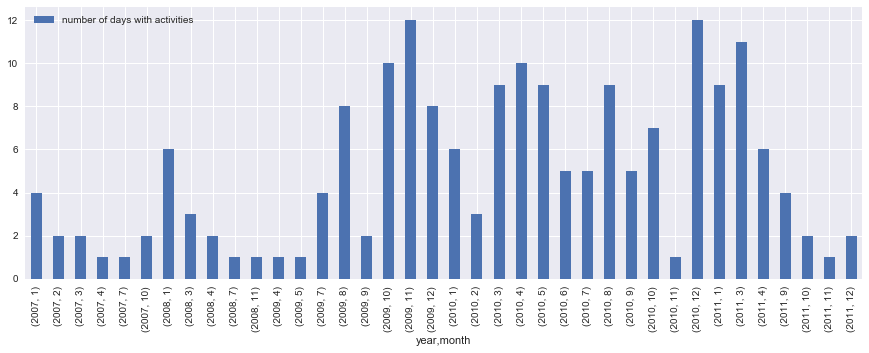

In [56]:
cnt.plot.bar(figsize=(15,5))

### <a id="09"/>以上資料是離散的x,y,z形式，適合畫成熱圖(heatmap)。以下改把資料以Seaborn套件畫成熱圖

In [57]:
cnt[:3]

number of days with activities
year month                                
2007 1                                   4
     2                                   2
     3                                   2

In [58]:
cnt.T

year                           2007                2008          ... 2010     \
month                            1  2  3  4  7  10   1  3  4  7  ...   10 11   
number of days with activities    4  2  2  1  1  2    6  3  2  1 ...    7  1   

year                               2011                     
month                           12   1   3  4  9  10 11 12  
number of days with activities  12    9  11  6  4  2  1  2  

[1 rows x 38 columns]

In [59]:
cnt.T.stack()

year                                  2007  2008  2009  2010  2011
                               month                              
number of days with activities 1       4.0   6.0   NaN     6   9.0
                               2       2.0   NaN   NaN     3   NaN
                               3       2.0   3.0   NaN     9  11.0
                               4       1.0   2.0   1.0    10   6.0
                               5       NaN   NaN   1.0     9   NaN
                               6       NaN   NaN   NaN     5   NaN
                               7       1.0   1.0   4.0     5   NaN
                               8       NaN   NaN   8.0     9   NaN
                               9       NaN   NaN   2.0     5   4.0
                               10      2.0   NaN  10.0     7   2.0
                               11      NaN   1.0  12.0     1   1.0
                               12      NaN   NaN   8.0    12   2.0

In [60]:
dat=cnt.T.stack().loc['number of days with activities']

建立含有色票序列的物件，等會以此色票序列畫熱圖：

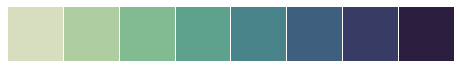

In [61]:
sns.palplot(sns.cubehelix_palette(8, start=.5, rot=-.75))

In [62]:
s=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

將資料轉置，因為我們想要畫月份於x軸：

In [63]:
dat.T

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2007,4.0,2.0,2.0,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN
2008,6.0,NaN,3.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
2009,NaN,NaN,NaN,1.0,1.0,NaN,4.0,8.0,2.0,10.0,12.0,8.0
2010,6.0,3.0,9.0,10.0,9.0,5.0,5.0,9.0,5.0,7.0,1.0,12.0
2011,9.0,NaN,11.0,6.0,NaN,NaN,NaN,NaN,4.0,2.0,1.0,2.0


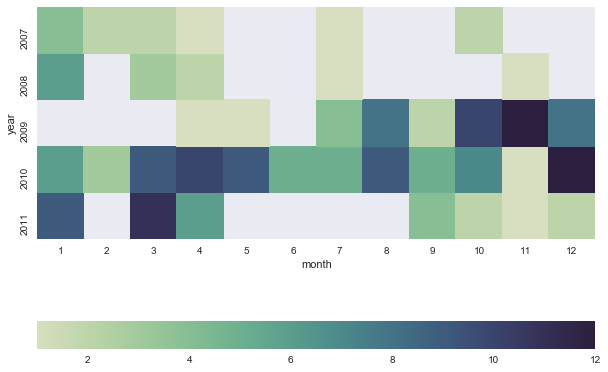

In [64]:
fig,ax=plt.subplots(figsize=(10,10))
ax = sns.heatmap(dat.T,cmap=s,square=True,cbar_kws={"orientation": "horizontal"})

亦或可將此資料重新以長條圖呈現，只是可能仍然沒有熱圖易懂：

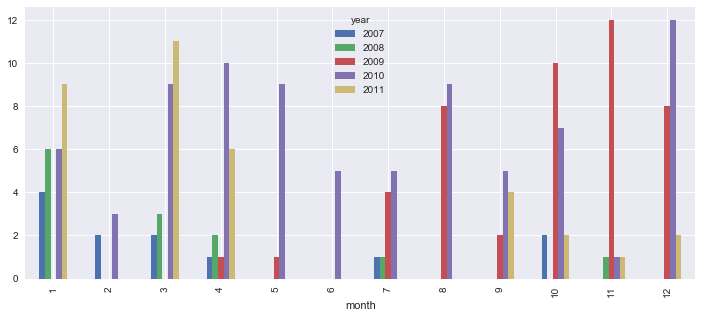

In [65]:
dat.plot.bar(figsize=(12,5))

---

問： <font color='darkred'> 一個DataFrame附加(append)至另一個DataFrame</font>與<font color='darkred'>一個清單附加至另一個清單</font>，哪一個方式較快？

In [66]:
df=pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]])

In [67]:
df2=pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]])

In [68]:
%%time
for j in range(2000):
    df=df.append(df2)

CPU times: user 1.38 s, sys: 20.6 ms, total: 1.41 s
Wall time: 1.54 s


In [69]:
lst1=[[1,2,3],[4,5,6],[7,8,9]]

In [70]:
lst2=[[1,2,3],[4,5,6],[7,8,9]]

In [71]:
%%time
for j in range(2000):
    for k in lst2:
        lst1.append(k)

#print(lst1)
df=pd.DataFrame(lst1)

CPU times: user 11.2 ms, sys: 1.33 ms, total: 12.6 ms
Wall time: 12.4 ms


(DataFrame附加DataFrame的過程中，會產生新的DataFrame，用以放置原來的兩個DataFrame。這個多出來的步驟會減緩附加DataFrame的速度)